# Compulsory 2 - Erlend Risvik

Start by loading in the secret ID

In [1]:
import ast
import requests
import pandas as pd
from pyspark.sql import SparkSession
import os

SECRET_INFO = open("../NO_SYNC/weather_api", 'r').read().replace('\n', '')
SECRET_ID = ast.literal_eval(SECRET_INFO)["client_id"]

In CA1, we selected locality 12765.

Let's start by finding out the GPS coordinates of our locality

In [2]:
os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

(spark.read.format("org.apache.spark.sql.cassandra")
 .options(table="fish_data_full", keyspace="compulsory")
 .load()
 .createOrReplaceTempView("fish_data_full"))

fish_data = spark.sql("select localityno, lon, lat, municipality, name from fish_data_full").toPandas()

In [3]:
# Select the GPS coordinates of locality 12765, and separate them by space
lat = round(fish_data.loc[fish_data['localityno'] == 12765, 'lat'].values[0], 3)
lon = round(fish_data.loc[fish_data['localityno'] == 12765, 'lon'].values[0], 3)
# Select the municipality and name of the same locality

municipality = fish_data.loc[fish_data['localityno'] == 12765, 'municipality'].values[0]
name = fish_data.loc[fish_data['localityno'] == 12765, 'name'].values[0]

# print lon, lat, municipality, name in f string nicely
print(f"Lon: {lon:.4f}\nLat: {lat:.4f}\nMunicipality: {municipality}\nPlace: {name}")

Lon: 9.9740
Lat: 62.0940
Municipality: Folldal
Place: Aasen Gård


In [68]:
endpoint = 'https://frost.met.no/sources/v0.jsonld'
parameters = {
"geometry" : f"nearest(POINT({lon} {lat}))",
"nearestmaxcount": 15,
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(SECRET_ID,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


In [70]:
# Go through each json object in the data list, and print the shortname, id and distance
for item in data:
    print(f"Shortname: {item['shortName']}\nID: {item['id']}\nDistance: {item['distance']}\n")
    

Shortname: Grimse 
ID: SN9050
Distance: 3.55522119643

Shortname: Folldal 
ID: SN9160
Distance: 3.95215517934

Shortname: Folldal (Li bru)
ID: SN8780
Distance: 9.44318857176

Shortname: FV29 Gravbekklia
ID: SN9250
Distance: 16.62512550816

Shortname: Atnsjøen
ID: SN8720
Distance: 24.25914849366

Shortname: Einunna
ID: SN8970
Distance: 24.47754731071

Shortname: Hjerkinn
ID: SN9310
Distance: 26.478453523970003

Shortname: E6 Hjerkinn
ID: SN9303
Distance: 27.607994447699998

Shortname: E6 Avsjøen
ID: SN16620
Distance: 27.655905071

Shortname: E6 Grønbakken
ID: SN63940
Distance: 28.53821021009

Shortname: Alvdal 
ID: SN8880
Distance: 34.00673936603

Shortname: Høvringen
ID: SN16271
Distance: 34.483657391369995

Shortname: RV3 Bergerønningen
ID: SN9400
Distance: 34.70172348205

Shortname: E6 Fokstugu
ID: SN16611
Distance: 35.83972754819

Shortname: Fokstugu
ID: SN16610
Distance: 35.84706832411



In [137]:
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': 'SN16610',
    'elements': 'sum(precipitation_amount P1D), mean(air_temperature P1D), mean(wind_speed P1D), mean(relative_humidity P1D)',
    'referencetime': '2015-01-01/2015-12-31',
    'levels' : 'default',
    'timeoffsets': 'default'
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(SECRET_ID,''))
# Extract JSON data
json = r.json()

In [143]:
# print lentgh of data
print(f"Length of data: {len(json['data'])}")


Length of data: 364


In [173]:
df = pd.DataFrame()
data = json['data']
for i in range(len(data)):
    row = pd.DataFrame(data[i]['observations'])
    row['referenceTime'] = data[i]['referenceTime']
    row['sourceId'] = data[i]['sourceId']
    df = pd.concat([df, row], ignore_index=True)

df = df.reset_index(drop=True)

columns = ['sourceId','referenceTime','elementId','value','unit','timeOffset']
df2 = df[columns].copy()
df2['referenceTime'] = pd.to_datetime(df2['referenceTime']).dt.strftime('%Y-%m-%d')
df2

,sourceId,referenceTime,elementId,value,unit,timeOffset
0,SN16610:0,2015-01-01,sum(precipitation_amount P1D),0.1,mm,PT6H
1,SN16610:0,2015-01-01,mean(air_temperature P1D),0.9,degC,PT0H
2,SN16610:0,2015-01-01,mean(wind_speed P1D),5.7,m/s,PT0H
3,SN16610:0,2015-01-01,mean(relative_humidity P1D),76.0,percent,PT0H
4,SN16610:0,2015-01-02,sum(precipitation_amount P1D),2.2,mm,PT6H
...,...,...,...,...,...,...
1449,SN16610:0,2015-12-29,mean(relative_humidity P1D),83.0,percent,PT0H
1450,SN16610:0,2015-12-30,sum(precipitation_amount P1D),2.3,mm,PT6H
1451,SN16610:0,2015-12-30,mean(air_temperature P1D),-3.2,degC,PT0H
1452,SN16610:0,2015-12-30,mean(wind_speed P1D),16.1,m/s,PT0H


In [175]:
# convert from wide to long format
df3 = df2.pivot(index='referenceTime', columns='elementId', values='value').reset_index()
# give better column names
df3.columns = ['date', 'precipitation', 'temperature', 'wind_speed', 'humidity']


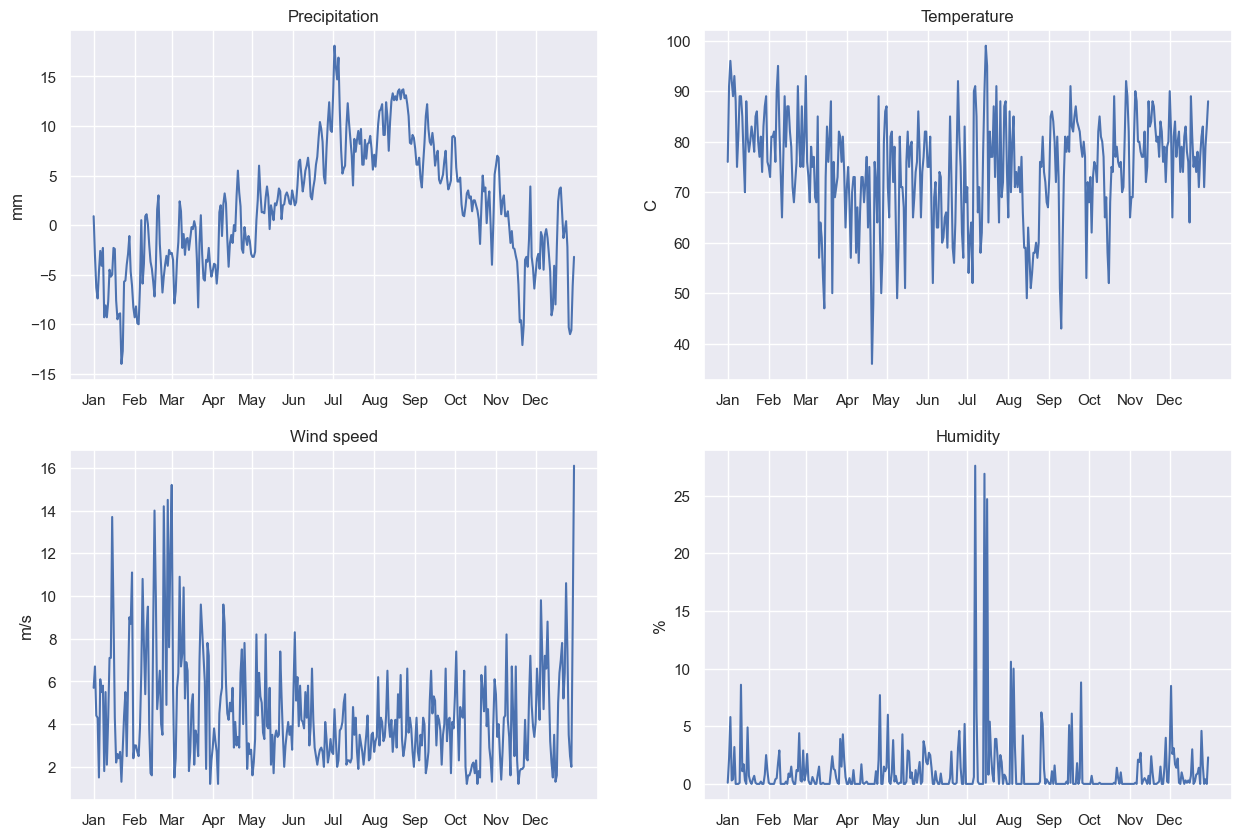

In [183]:
# plot the four variables

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ticks = ['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01']
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

sns.lineplot(ax=axes[0, 0], data=df3, x='date', y='precipitation')
axes[0, 0].set_title('Precipitation')
axes[0, 0].set_xticks(ticks)
axes[0, 0].set_xticklabels(labels)
axes[0, 0].set_ylabel('mm')

sns.lineplot(ax=axes[0, 1], data=df3, x='date', y='temperature')
axes[0, 1].set_title('Temperature')
axes[0, 1].set_xticks(ticks)
axes[0, 1].set_xticklabels(labels)
axes[0, 1].set_ylabel('C')

sns.lineplot(ax=axes[1, 0], data=df3, x='date', y='wind_speed')
axes[1, 0].set_title('Wind speed')
axes[1, 0].set_xticks(ticks)
axes[1, 0].set_xticklabels(labels)
axes[1, 0].set_ylabel('m/s')

sns.lineplot(ax=axes[1, 1], data=df3, x='date', y='humidity')
axes[1, 1].set_title('Humidity')
axes[1, 1].set_xticks(ticks)
axes[1, 1].set_xticklabels(labels)
axes[1, 1].set_ylabel('%')

# hide the x label "date"
for ax in axes.flat:
    ax.set(xlabel='')


